<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/GAN/DCGAN(2015).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference
- https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터셋 불러오기

In [2]:
# 데이터 경로 지정
path2data = './data'
os.makedirs(path2data, exist_ok=True)

In [3]:
# transforms 정의하기
h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = transforms.Compose([
                    transforms.Resize((h,w)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
])

In [4]:
# STL-10 dataset 불러오기
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transform)


Extracting ./data/stl10_binary.tar.gz to ./data


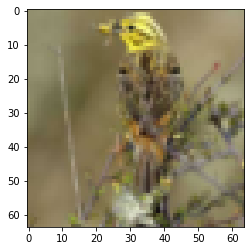

In [5]:
# 샘플 이미지 확인
img, label = train_ds[0]
plt.imshow(to_pil_image(0.5*img+0.5))

In [6]:
# DataLoader 생성하기
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 모델 구축하기

In [7]:
# 파라미터 정의
params = {'nz':100, # noise 수
          'ngf':64, # generator에서 사용하는 conv filter 수
          'ndf':64, # discriminator에서 사용하는 conv filter 수
          'img_channel':3, # 이미지 채널
          }

In [8]:
# Generator: noise를 입력받아 가짜 이미지를 생성합니다.
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        nz = params['nz'] # noise 수, 100
        ngf = params['ngf'] # conv filter 수
        img_channel = params['img_channel'] # 이미지 채널

        self.dconv1 = nn.ConvTranspose2d(nz,ngf*8,4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        self.dconv2 = nn.ConvTranspose2d(ngf*8,ngf*4, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*4)
        self.dconv3 = nn.ConvTranspose2d(ngf*4,ngf*2,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)
        self.dconv4 = nn.ConvTranspose2d(ngf*2,ngf,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.dconv5 = nn.ConvTranspose2d(ngf,img_channel,4,stride=2,padding=1,bias=False)

    def forward(self,x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))
        x = F.relu(self.bn3(self.dconv3(x)))
        x = F.relu(self.bn4(self.dconv4(x)))
        x = torch.tanh(self.dconv5(x))
        return x

# check
x = torch.randn(1,100,1,1, device=device)
model_gen = Generator(params).to(device)
out_gen = model_gen(x)
print(out_gen.shape)

torch.Size([1, 3, 64, 64])


In [9]:
# Discriminator: 진짜 이미지와 가짜 이미지를 식별합니다.
class Discriminator(nn.Module):
    def __init__(self,params):
        super().__init__()
        img_channel = params['img_channel'] # 3
        ndf = params['ndf'] # 64

        self.conv1 = nn.Conv2d(img_channel,ndf,4,stride=2,padding=1,bias=False)
        self.conv2 = nn.Conv2d(ndf,ndf*2,4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2,ndf*4,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4,ndf*8,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*8)
        self.conv5 = nn.Conv2d(ndf*8,1,4,stride=1,padding=0,bias=False)

    def forward(self,x):
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        x = torch.sigmoid(self.conv5(x))
        return x.view(-1,1)

# check
x = torch.randn(16,3,64,64,device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x)
print(out_dis.shape)

torch.Size([16, 1])


In [10]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

# 학습하기

In [11]:
# 손실 함수 정의
loss_func = nn.BCELoss()

# 최적화 함수
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))

In [17]:
model_gen.train()
model_dis.train()

batch_count=0
num_epochs=100
start_time = time.time()
nz = params['nz'] # 노이즈 수 100
loss_hist = {'dis':[],
             'gen':[]}

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.shape[0]

        xb = xb.to(device)
        yb_real = torch.Tensor(ba_si,1).fill_(1.0).to(device)
        yb_fake = torch.Tensor(ba_si,1).fill_(0.0).to(device)

        # generator
        model_gen.zero_grad()

        z = torch.randn(ba_si,nz,1,1).to(device) # noise
        out_gen = model_gen(z) # 가짜 이미지 생성
        out_dis = model_dis(out_gen) # 가짜 이미지 식별

        g_loss = loss_func(out_dis,yb_real)
        g_loss.backward()
        opt_gen.step()

        # discriminator
        model_dis.zero_grad()
        
        out_dis = model_dis(xb) # 진짜 이미지 식별
        loss_real = loss_func(out_dis,yb_real)

        out_dis = model_dis(out_gen.detach()) # 가짜 이미지 식별
        loss_fake = loss_func(out_dis,yb_fake)

        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 6.871725, D_Loss: 0.275625, time: 0.17 min
Epoch: 2, G_Loss: 2.215611, D_Loss: 0.120297, time: 0.32 min
Epoch: 3, G_Loss: 2.994767, D_Loss: 0.363048, time: 0.46 min
Epoch: 5, G_Loss: 2.931833, D_Loss: 0.154363, time: 0.61 min
Epoch: 6, G_Loss: 6.852765, D_Loss: 0.680597, time: 0.76 min
Epoch: 7, G_Loss: 4.570507, D_Loss: 0.148297, time: 0.91 min
Epoch: 8, G_Loss: 3.080893, D_Loss: 0.087121, time: 1.05 min
Epoch: 10, G_Loss: 1.855008, D_Loss: 0.268768, time: 1.20 min
Epoch: 11, G_Loss: 3.662749, D_Loss: 0.123258, time: 1.35 min
Epoch: 12, G_Loss: 6.151712, D_Loss: 0.165932, time: 1.50 min
Epoch: 13, G_Loss: 7.978763, D_Loss: 0.449618, time: 1.65 min
Epoch: 15, G_Loss: 5.069977, D_Loss: 0.097061, time: 1.79 min
Epoch: 16, G_Loss: 1.233518, D_Loss: 0.326546, time: 1.94 min
Epoch: 17, G_Loss: 1.907828, D_Loss: 0.234177, time: 2.09 min
Epoch: 18, G_Loss: 3.178129, D_Loss: 0.151087, time: 2.24 min
Epoch: 20, G_Loss: 2.743143, D_Loss: 0.123513, time: 2.38 min
Epoch: 21, G_Lo

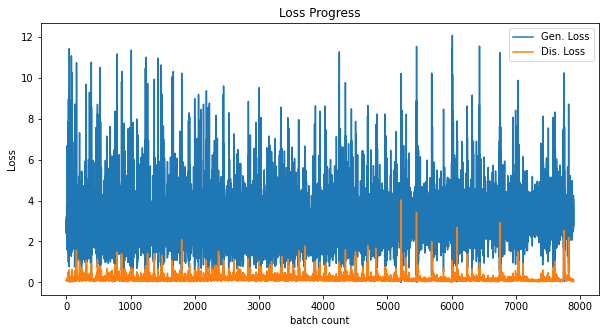

In [19]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

# Generator이 생성한 가짜 이미지 확인하기

In [26]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100,1,1, device=device)
    label = torch.randint(0,10,(16,), device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 3, 64, 64])


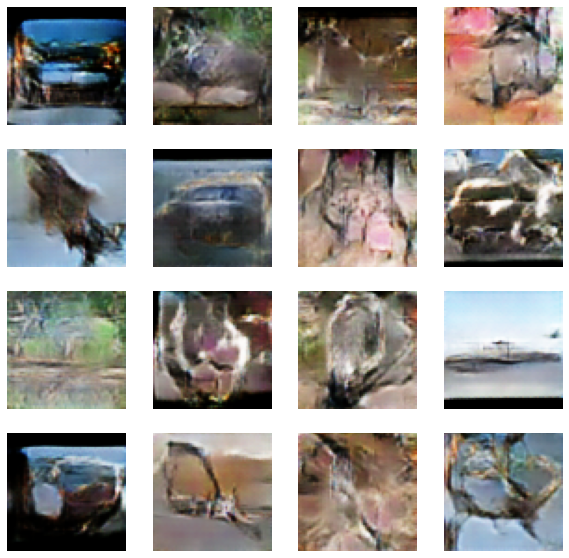

In [27]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5), cmap='gray')
    plt.axis('off')